In [1]:
import matplotlib.pyplot as plt
import sciris as sc
import numpy as np
import starsim as ss
from starsim.time import * # Import the date classes directly to make the examples more readable

# V3 Time API

*Implementation goals*

- Want simulations to be safer - make it harder to write running code with incorrect results (e.g., forgetting a scaling factor, or having the units indirectly change)
- Balance type formality with flexibility, want to make things safe without being overly tedious (although lean towards explicit rather than implicit)
- Want simulations to be interoperable with calendar dates and numeric points in time (e.g., numerical years)

# Dates

In [2]:
Date('2020-01-01')

<2020.01.01>

In [3]:
Date(2020)

<2020.01.01>

In [4]:
Date(2020.1)

<2020.02.06 14:23:59>

## Arrays of dates

It is common to require an array of dates that is independent of any simulation timesteps - for example, interventions may have an attribute like `years = np.arange(2000,2020)` to align with data, even though the intervention is run with the same timestep as the main simulation. To facilitate these use cases, the `Date` class provides constructors for arrays as follows:

In [5]:
Date.from_array([2000,2001,2002])

array([<2000.01.01>, <2001.01.01>, <2002.01.01>], dtype=object)

In [6]:
Date.arange(2000,2003)

array([<2000.01.01>, <2001.01.01>, <2002.01.01>], dtype=object)

# Durations

In [7]:
YearDur(1)

<YearDur: 1 years>

In [8]:
YearDur(0.2)

<YearDur: 0.2 years>

In [9]:
DateDur(days=1)

<DateDur: days=1>

In [10]:
DateDur(weeks=1)

<DateDur: weeks=1>

In [11]:
2*DateDur(weeks=1)

<DateDur: weeks=2>

In [12]:
DateDur(weeks=1)+DateDur(years=1)

<DateDur: years=1,weeks=1>

This type only supports integers for each of the time periods. If division would result in a fractional number of units, they will be rolled over to smaller units. For example, half a week is 3.5 days, and the half-day is rolled over to become 12 hours:

In [13]:
DateDur(weeks=1)/2

<DateDur: days=3, +12:00:00>

## Type interoperability

The two duration types are interoperable based on preset ratios

In [14]:
Dur.ratios

#0. 'years':        1
#1. 'months':       12
#2. 'weeks':        4.348214285714286
#3. 'days':         7
#4. 'hours':        24
#5. 'minutes':      60
#6. 'seconds':      60
#7. 'milliseconds': 1000
#8. 'microseconds': 1000
#9. 'nanoseconds':  1000

For mixed types, the order determines the output type

In [15]:
DateDur(weeks=1)+YearDur(1)

<DateDur: years=1,weeks=1>

In [16]:
YearDur(1)+DateDur(weeks=1)

<YearDur: 1.0191649555099247 years>

In [17]:
DateDur(weeks=1)+YearDur(1.5)

<DateDur: years=1,months=6,weeks=1>

In [18]:
DateDur(days=7)-DateDur(days=1)

<DateDur: days=6>

In [19]:
DateDur(weeks=1)-DateDur(days=1)

<DateDur: weeks=1,days=-1>

In [20]:
(DateDur(days=7)-DateDur(days=1)).years

0.01642710472279261

In [21]:
(DateDur(weeks=1)-DateDur(days=1)).years

0.016427104722792605

## Why have both duration types?

The two duration types are needed because simulations may or may not care about specific calendar dates during the year, and the variable duration of months and years (in terms of number of days) means that an exact mapping from one type of duration to the other is not possible. Essentially

- Some simulations will want to prioritise having a specific number of timesteps per year e.g., 12 or 52 timesteps per year
- Some simulations will want a specific number of weeks or months to elapse e.g., if the day of the week matters for things like school contacts

The example below demonstrates how 52 weeks with a `DateDur` leads to a different result compare to the approximation of 52 weeks per year, using a `YearDur` instance:


In [22]:
Date('2020-01-01')+DateDur(days=1)

<2020.01.02>

In [23]:
Date('2020-01-01')+DateDur(weeks=1)

<2020.01.08>

In [24]:
Date('2020-01-01')+52*DateDur(weeks=1)

<2020.12.30>

In [25]:
Date('2020-01-01')+52*YearDur(1/52)

<2021.01.01>

Subtraction of durations from dates is fine, and behaves as expected:

In [26]:
Date('2020-01-01')-DateDur(days=1)

<2019.12.31>

In [27]:
Date('2020-01-01')-DateDur(days=6)

<2019.12.26>

This example should be read as 'go back 1 week, then go forward 1 day' hence this is equivalent to going back 6 days, and gives the same result as the example above:

In [28]:
Date('2020-01-01')-(DateDur(weeks=1)-DateDur(days=1))

<2019.12.26>

## Combined constructor

The `Dur` constructor can be used as a single entry point for constructing `Dur` instances, where a numerical input leads to creation of a `YearDur` instance, while kwargs are used to produce a `DateDur` instance:

In [29]:
Dur(1)

<YearDur: 1 years>

In [30]:
Dur(years=1)

<DateDur: years=1>

## Scaling factors

Quantities are absolute so scaling factors can be calculated on demand

In [31]:
Dur(2)/Dur(1)

2.0

In [32]:
Dur(weeks=1)/Dur(days=1)

7.0

In [33]:
Dur(weeks=1)/Dur(1)

0.019164955509924708

In [34]:
Dur(weeks=1)/Dur(1/365)

6.995208761122518

In [35]:
Dur(1/52)/Dur(1/365)

7.019230769230769

## Helper functions

To facilitate constructing common durations, helper functions are available:

In [36]:
years(1)

<YearDur: 1 years>

In [37]:
months(1)

<DateDur: months=1>

In [38]:
weeks(1)

<DateDur: weeks=1>

In [39]:
days(1)

<DateDur: days=1>

# Numerical interoperability

A common use case is working with calendar dates, and therefore years as a natural unit of time. Although we would recommend using date and duration objects everywhere these quantities are used, it would make and migration easier for a significant proportion of users if bare numbers could be interpreted as years. This mainly applies to comparison operators, so for example:

In [40]:
Date(2005)>2000

True

In [41]:
YearDur(1) < 2

True

In [42]:
DateDur(days=1)<2

True

This functionality is mainly aimed at easing the migration workload for users that have written code like `years = np.arange(2000,2020)`. However, we would recommend migration to `years = ss.Date.arange(2000,2020)` instead.

# Rates

Rates represent a value per unit time. They can be constructed either by taking the inverse of a duration, or by passing the value and associated period directly:

In short, we facilitate compatibility with `years = np.arange(2000,2020)` to decrease migration workload, but strongly recommend migration to `years = ss.Date.arange(2000,2020)`.

## Creating rates

In [43]:
1/DateDur(days=1)

<Rate: 1 per day>

In [44]:
Rate(1, Dur(1))

<Rate: 1 per year>

In [45]:
Rate(1, Dur(months=1))

<Rate: 1 per month>

If no period is provided, 1 year is assumed:

In [46]:
Rate(2)

<Rate: 2 per year>

## Scaling and adding rates

Rates can be scaled up or down multiplicatively. This operation does not affect the time period associated with the rate, so the action of scaling can be directly matched with the displayed value:

In [47]:
2*Rate(2)

<Rate: 4 per year>

In [48]:
4.5*Rate(1, Dur(months=1))

<Rate: 4.5 per month>

Rates can also be combined. When adding or subtracting rates, the reference time period will be drawn from the left hand side e.g.

In [49]:
Rate(1,Dur(weeks=1))+Rate(1,Dur(days=1))

<Rate: 8.0 per week>

In [50]:
Rate(1,Dur(days=1))+Rate(1,Dur(weeks=1))

<Rate: 1.1428571428571428 per day>

This is intended to ease working with rates where the user has a natural reference time period (e.g., weeks, days) and wants to manipulate the rate using the same time period. So again, the action of the addition can be evaluated on the same time period as the original rate, with conversions of the other rate automatically applied as required. 

## Multiplication by durations

Crucially, rates can be multiplied by a duration to get the a dimensionless number per time period (usually per timestep). For example, if we have a rate of 1 per year, and multiply it by 2 years, we would get a value of 2

In [51]:
Rate(1) * Dur(2)

2.0

Similarly, if we could have a rate of 1 per year, and multiply it by 1 week:

In [52]:
Rate(1) * Dur(weeks=1)

0.019164955509924708

In the example above, we two rates were added together, and the output rate depended on the order of the addition. However, these rates are equivalent and behave the same way (to within numerical precision) when multiplied by a duration e.g.,

In [53]:
(Rate(1,Dur(weeks=1))+Rate(1,Dur(days=1)))*Dur(weeks=1) # <Rate: 8.0 per week> * 1 week = 8

8.0

In [54]:
(Rate(1,Dur(days=1))+Rate(1,Dur(weeks=1)))*Dur(weeks=1) # <Rate: 1.142857...  per day> * 1 week = 8

7.999999999999989

## Division

Just as the inverse of a duration is a rate, the inverse of a rate is a duration:

In [55]:
1/Rate(1,Dur(days=1))

<DateDur: days=1>

If a rate is divided by another rate, the result is a dimensionless fraction e.g.

In [56]:
Rate(14,weeks(1))/Rate(1,days(1))  # 14 per week, divided by 1 per day (=7 per week), gives 14/7=2

2.0

## Helper functions

To faciliate constructing rates, helper methods for common reference time periods are provided:

In [57]:
peryear(1)

<Rate: 1 per year>

In [58]:
permonth(1)

<Rate: 1 per month>

In [59]:
perweek(1)

<Rate: 1 per week>

In [60]:
perday(1)

<Rate: 1 per day>

# Probability rates

There are two other quantities closely related to rates

- A probability per unit time
- A rate that should be converted to a probability 

These are implemented with the `TimeProb` and `RateProb` classes, respectively. They are essentially identical to `Rate` instances, except that multiplication by a duration results in a probability being returned, which involves conversion to a cumulative hazard rate rather than just direct linear multiplication of the rate. For example, suppose we had a process where the probability per year was 0.1. This can be captured with:

In [61]:
p = TimeProb(0.1, Dur(1))

If we multiply this by 1 year, we will get back the same probability

In [62]:
p*Dur(1)

0.09999999999999998

However, if we multiply it by 2 years to get the probability per 2 year period, we get less than double the value:

In [63]:
p*Dur(2)

0.18999999999999995

Similarly, if we multiply by half a year, to get the probability per 6 month period, we get more than half the value:

In [64]:
p*Dur(0.5)

0.05131670194948623

# Time vectors

Creation of time vectors is based around the `Date.arange` function but goes beyond that, because the `Time` object stored in Starsim modules has both date/dur and year-based representations, as well as explicitly tracks the timestep. After creating a `Time` object, it is necessary to initialise it. This is because initialisation accepts a `Sim` object, which is used to populate unspecified values based on the `Sim`. If no `Sim` is provided during initialisation, standard default values will be used. 

If all that is needed is an array of dates, use `Date.arange` e.g.

In [65]:
Date.arange(Date('2020-01-01'), Date('2030-02-01'), Dur(days=1))

array([<2020.01.01>, <2020.01.02>, <2020.01.03>, ..., <2030.01.30>,
       <2030.01.31>, <2030.02.01>], dtype=object)

Alternatively, a full `Time` instance can be constructed, in which case `Time.tvec` corresponds to the dates:

In [66]:
t = Time(Date('2020-01-01'), Date('2030-02-01'), Dur(days=1)).init()
t.tvec

array([<2020.01.01>, <2020.01.02>, <2020.01.03>, ..., <2030.01.30>,
       <2030.01.31>, <2030.02.01>], dtype=object)

In the same way that durations can be added to a single date, they can be added to an array of dates:

In [67]:
t.tvec + Dur(days=1)

array([<2020.01.02>, <2020.01.03>, <2020.01.04>, ..., <2030.01.31>,
       <2030.02.01>, <2030.02.02>], dtype=object)

In [68]:
t.tvec + Dur(1/12)

array([<2020.01.31 11:59:59>, <2020.02.01 11:59:59>,
       <2020.02.02 11:59:59>, ..., <2030.03.01 09:59:59>,
       <2030.03.02 09:59:59>, <2030.03.03 09:59:59>], dtype=object)

In [69]:
t.tvec + Dur(months=1)

array([<2020.02.01>, <2020.02.02>, <2020.02.03>, ..., <2030.02.28>,
       <2030.02.28>, <2030.03.01>], dtype=object)

Plots can be made using dates on the x-axis e.g.,

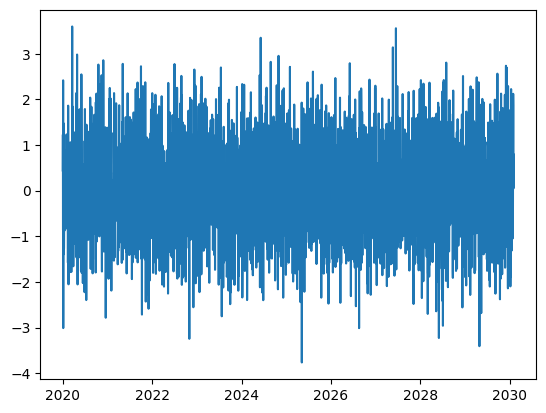

In [70]:
plt.plot(t.tvec, np.random.randn(len(t.tvec)));

Outbreak simulations would be run using a time vector based on durations

In [71]:
t = Time(Dur(0), Dur(1), Dur(1/12)).init()
t.tvec

array([<YearDur: 0.0 years>, <YearDur: 0.083333333333 years>,
       <YearDur: 0.166666666667 years>, <YearDur: 0.25 years>,
       <YearDur: 0.333333333333 years>, <YearDur: 0.416666666667 years>,
       <YearDur: 0.5 years>, <YearDur: 0.583333333333 years>,
       <YearDur: 0.666666666667 years>, <YearDur: 0.75 years>,
       <YearDur: 0.833333333333 years>, <YearDur: 0.916666666667 years>,
       <YearDur: 1.0 years>], dtype=object)

These can be plotted directly

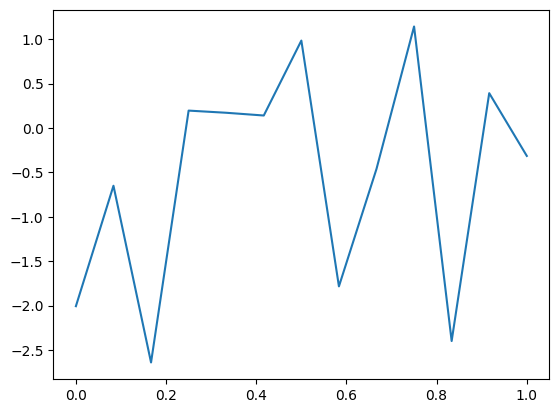

In [72]:
plt.plot(t.tvec, np.random.randn(len(t.tvec)));

In [73]:
t = Time(Dur(days=0), Dur(days=30), Dur(days=1)).init()
t.tvec

array([<DateDur: 0>, <DateDur: days=1>, <DateDur: days=2>,
       <DateDur: days=3>, <DateDur: days=4>, <DateDur: days=5>,
       <DateDur: days=6>, <DateDur: days=7>, <DateDur: days=8>,
       <DateDur: days=9>, <DateDur: days=10>, <DateDur: days=11>,
       <DateDur: days=12>, <DateDur: days=13>, <DateDur: days=14>,
       <DateDur: days=15>, <DateDur: days=16>, <DateDur: days=17>,
       <DateDur: days=18>, <DateDur: days=19>, <DateDur: days=20>,
       <DateDur: days=21>, <DateDur: days=22>, <DateDur: days=23>,
       <DateDur: days=24>, <DateDur: days=25>, <DateDur: days=26>,
       <DateDur: days=27>, <DateDur: days=28>, <DateDur: days=29>,
       <DateDur: days=30>], dtype=object)

These can be plotted directly as well - however, at the moment these are still in units of years elapsed - a todo item is to improve the default labelling (but at this stage does not appear to be worth delaying the release for). 

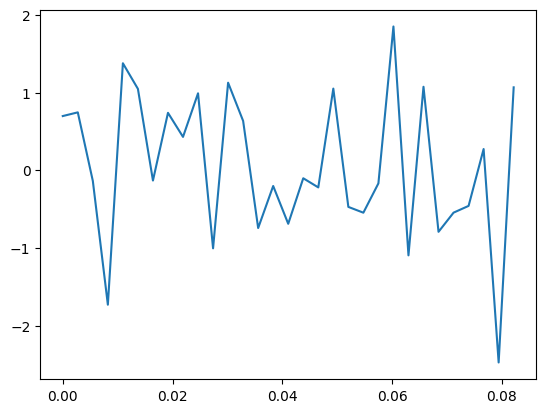

In [74]:
plt.plot(t.tvec, np.random.randn(len(t.tvec)));

A date could then be added to these to align the outbreak with calendar dates for comparison to data

In [75]:
t.tvec+Date('2020-01-01')

array([<2020.01.01>, <2020.01.02>, <2020.01.03>, <2020.01.04>,
       <2020.01.05>, <2020.01.06>, <2020.01.07>, <2020.01.08>,
       <2020.01.09>, <2020.01.10>, <2020.01.11>, <2020.01.12>,
       <2020.01.13>, <2020.01.14>, <2020.01.15>, <2020.01.16>,
       <2020.01.17>, <2020.01.18>, <2020.01.19>, <2020.01.20>,
       <2020.01.21>, <2020.01.22>, <2020.01.23>, <2020.01.24>,
       <2020.01.25>, <2020.01.26>, <2020.01.27>, <2020.01.28>,
       <2020.01.29>, <2020.01.30>, <2020.01.31>], dtype=object)

In [76]:
t.tvec+Date('2020-03-01')

array([<2020.03.01>, <2020.03.02>, <2020.03.03>, <2020.03.04>,
       <2020.03.05>, <2020.03.06>, <2020.03.07>, <2020.03.08>,
       <2020.03.09>, <2020.03.10>, <2020.03.11>, <2020.03.12>,
       <2020.03.13>, <2020.03.14>, <2020.03.15>, <2020.03.16>,
       <2020.03.17>, <2020.03.18>, <2020.03.19>, <2020.03.20>,
       <2020.03.21>, <2020.03.22>, <2020.03.23>, <2020.03.24>,
       <2020.03.25>, <2020.03.26>, <2020.03.27>, <2020.03.28>,
       <2020.03.29>, <2020.03.30>, <2020.03.31>], dtype=object)

The yearvec is available as well

In [77]:
t = Time(Date('2020-01-01'), Date('2030-02-01'), Dur(days=1)).init()
t.yearvec

array([2020.        , 2020.00273224, 2020.00546448, ..., 2030.07945205,
       2030.08219178, 2030.08493151])

In [78]:
t = Time(Dur(0), Dur(1), Dur(1/12)).init()
t.yearvec

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        ])

# Distributions

Distributions can be used without any changes, with dimensionless numbers interpreted as required by parent modules. In many cases, the distribution should be parametrized by a duration e.g., distribution of duration of infection. This is typically sampled per-agent, but for performance reasons, we need `Dist.rvs()` to return a bare numpy array that can be operated on natively. To achieve this, the distribution automatically converts any time parameters onto its parent timestep before calling `rvs`. Thus, the output of `rvs()` is specific to the timestep. Conversion is handled automatically. 

In order to demonstrate this functionality, it's necessary to also construct a mock module so that the `Dur` instance can carry out this conversion - normally of course, the `module` argument would correspond to the actual parent module for the distribution. In this case, we can see how a mean duration of 6 days maps to 6 timesteps, so the mean of the output from `d.rvs()` is 6:

In [79]:
module = sc.objdict(t=sc.objdict(dt=Dur(days=1)))
d = ss.normal(Dur(days=6), Dur(days=1), module=module, strict=False)
d.init()
d.rvs(5)

array([6.12573022, 5.86789514, 6.64042265, 6.10490012, 5.46433063])

Alternatively, consider exactly the same distribution, but in a case where the timestep is 1 week. Now, a mean duration of 6 days corresponds to a duration of 6/7 weeks. The output of `d.rvs()` now has a mean value of 6/7, even though the input parameters to `ss.normal` are unchanged. 

In [80]:
module = sc.objdict(t=sc.objdict(dt=Dur(weeks=1)))
d = ss.normal(Dur(days=6), Dur(days=1), module=module, strict=False)
d.init()
d.rvs(5)

array([0.87510432, 0.83827073, 0.94863181, 0.87212859, 0.78061866])

This conversion also works with function parameters, which can return time parameter instances. For instance


In [81]:
def loc(module, sim, uids):
    return Dur(days=5)

module = sc.objdict(t=sc.objdict(dt=Dur(days=1)))
d = ss.normal(loc, Dur(days=1), module=module, strict=False)
d.init()
d.rvs(5)

array([5.12573022, 4.86789514, 5.64042265, 5.10490012, 4.46433063])

In [82]:
def loc(module, sim, uids):
    return np.array([Dur(days=x) for x in range(uids)])

module = sc.objdict(t=sc.objdict(dt=Dur(days=1)))
d = ss.normal(loc, Dur(days=1), module=module, strict=False)
d.init()
d.rvs(20)

array([ 0.12573022,  0.86789514,  2.64042265,  3.10490012,  3.46433063,
        5.36159505,  7.30400005,  7.94708096,  7.29626476,  7.73457853,
        9.37672554, 11.04132598,  9.67496923, 12.78120834, 12.75408905,
       14.26773265, 15.45574102, 16.68369984, 18.41163054, 20.04251337])